# Summarize Void Growth and Movement
Determine whether time or size affect the mobility or growth rates of voids.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colormaps
from scipy.optimize import minimize
from scipy.stats import norm, lognorm
from functools import partial
from multiprocessing import Pool
from pathlib import Path
from cycler import cycle
import pandas as pd
import numpy as np
import emcee
import json

Configuration

In [2]:
run_directory = '../data/8bitTIFF-video24-550C'

Other key paths

In [3]:
run_directory = Path(run_directory)
run_name = run_directory.name
out_directory = Path('output') / run_name

## Load the Smoothed Tracks
We are going to start from the tasks after smoothing them with splines

In [4]:
track_data = pd.read_csv(out_directory / 'smoothed_tracks.csv')
print(f'Loaded {len(track_data)} records from {len(track_data["void"].value_counts())} voids')

Loaded 2558 records from 17 voids


In [5]:
track_data.head()

,void,frame,radius,radius_dt,velocity_mag,position-x,position-y,color
0,193,422,3.655775,-0.011185,0.006624,462.258592,135.588053,[0.225863 0.330805 0.547314 1. ]
1,118,400,4.293406,-0.008532,0.003046,139.535770,212.042469,[0.150148 0.676631 0.506589 1. ]
2,3,35,3.738911,0.029312,0.039266,464.777018,449.218899,[0.404001 0.800275 0.362552 1. ]
3,111,325,5.431482,0.000569,0.001144,70.459376,226.081019,[0.220124 0.725509 0.466226 1. ]
4,14,55,2.634231,-0.022364,0.214583,74.598702,226.975201,[0.13777 0.537492 0.554906 1. ]


## Detect Outliers
See if any of the growth rates are particularly unlikely compared to the others. We are going to use methods based on the IQR for simplicity's sake

### Growth
From the previous notebook, we can see that growth terms are relatively smooth. So, I'm leery to refer to points as outliers unless they are far out

In [6]:
iqr_rdt = np.diff(np.percentile(track_data['radius_dt'], [25, 75]))[0]

In [7]:
k = 5  # Based on https://aakinshin.net/posts/tukey-outlier-probability/
upper_thr = np.percentile(track_data['radius_dt'], 75) + k * iqr_rdt
lower_thr = np.percentile(track_data['radius_dt'], 25) - k * iqr_rdt

Text(0, 0.5, 'Count')

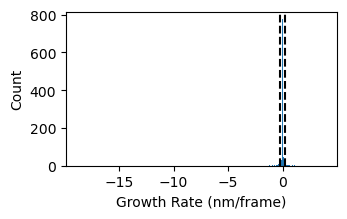

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.hist(track_data['radius_dt'], bins=1024)

ax.set_ylim(ax.get_ylim())
for thr in [lower_thr, upper_thr]:
    ax.plot([thr]*2, ax.get_ylim(), 'k--')

ax.set_xlabel('Growth Rate (nm/frame)')
ax.set_ylabel('Count')

In [9]:
track_data['growth_outlier'] = np.logical_or(track_data['radius_dt'] > upper_thr, track_data['radius_dt'] < lower_thr)
print(f'Found {track_data["growth_outlier"].sum()} outliers')

Found 359 outliers


### Movement
Movement is more jittery but I need to be less aggressive on movement rates because most voids are sessile. Only the rare void moves

In [10]:
iqr_rdt = np.diff(np.percentile(track_data['velocity_mag'], [25, 75]))[0]

In [11]:
k = 8  # Based on https://aakinshin.net/posts/tukey-outlier-probability/
upper_thr = np.percentile(track_data['velocity_mag'], 75) + k * iqr_rdt
lower_thr = np.percentile(track_data['velocity_mag'], 25) - k * iqr_rdt
print(f'Bounds for movement: {upper_thr:.3f}, {lower_thr:.3f}')

Bounds for movement: 0.865, -0.757


Text(0, 0.5, 'Count')

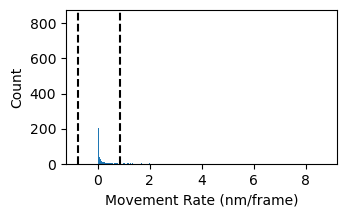

In [12]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.hist(track_data['velocity_mag'], bins=1024)

ax.set_ylim(ax.get_ylim())
for thr in [lower_thr, upper_thr]:
    ax.plot([thr]*2, ax.get_ylim(), 'k--')

ax.set_xlabel('Movement Rate (nm/frame)')
ax.set_ylabel('Count')

In [13]:
track_data['movement_outlier'] = np.logical_or(track_data['velocity_mag'] > upper_thr, track_data['velocity_mag'] < lower_thr)
print(f'Found {track_data["movement_outlier"].sum()} outliers')

Found 179 outliers


### Drop outliers
Exclude if it is an outlier for either

In [14]:
old_size = len(track_data)
track_data.query('not (movement_outlier or growth_outlier)', inplace=True)
print(f'New size: {len(track_data)}. {len(track_data) / old_size * 100:.2f}% passed.')

New size: 2162. 84.52% passed.


## Re-plot the void tracks
Drop the first and last 5 frames of the void track. Those are right where the void moved or changed enough that it 

Assign a random color to each void

In [15]:
cmap = colormaps['nipy_spectral']

In [16]:
colors = np.linspace(0, 1, len(track_data['void'].value_counts()))
rng = np.random.RandomState(1)
rng.shuffle(colors)
colors = cmap(colors)

In [17]:
known_voids = sorted(set(track_data['void']))
track_data['color'] = track_data['void'].apply(known_voids.index).apply(colors.__getitem__)

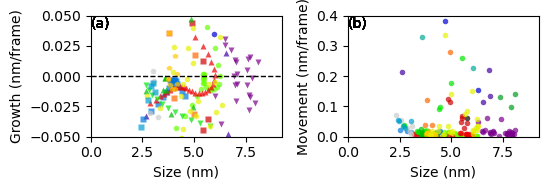

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.), sharex=True)

alpha = 0.7

# Plot the growth
ax = axs[0]
for (gid, group), m in zip(track_data.groupby('void'), cycle('osv^p')):
    ax.text(0, 0.9, '(a)', transform=ax.transAxes, fontsize=10, weight='normal')
    group = group.sort_values('frame')
    
    # Determine the color for this group
    color = group['color'].iloc[0].tolist()
    color[3] = alpha  # Set the alpha
    ax.plot(group['radius'], group['radius_dt'], m, 
            ms=4, lw=1, mfc=color, mec='none', markevery=12)

ax.set_xlim(0, max(ax.get_xlim()) * 1.1)
ax.plot(ax.get_xlim(), [0, 0], 'k--', lw=1)
ax.set_ylabel('Growth (nm/frame)')
ax.set_ylim(-0.05, 0.05)

# Plot the movement
ax = axs[1]
for gid, group in track_data.groupby('void'):
    ax.text(0, 0.9, '(b)', transform=ax.transAxes, fontsize=10, weight='normal')
    # Determine the color for this group
    color = group['color'].iloc[0].tolist()
    color[3] = alpha  # Set the alpha
    ax.plot(group['radius'], group['velocity_mag'], 'o', 
            ms=4, lw=1, mfc=color, mec='none', markevery=12)

ax.set_ylim(0, 0.4)
ax.set_ylabel('Movement (nm/frame)')

for ax in axs:
    ax.set_xlabel('Size (nm)')
fig.tight_layout()
fig.savefig(out_directory / 'figures/time-resolved-voids-by-size.png', dpi=320)

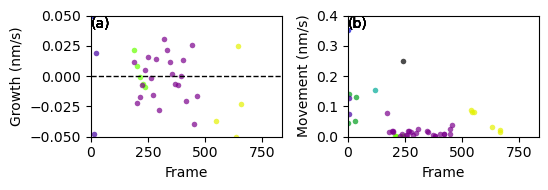

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.), sharex=True)

alpha = 0.7

# Plot the growth
ax = axs[0]
for gid, group in track_data.query('radius > 6').groupby('void'):
    ax.text(0, 0.9, '(a)', transform=ax.transAxes, fontsize=10, weight='normal')
    group = group.sort_values('frame')
    
    # Determine the color for this group
    color = group['color'].iloc[0].tolist()
    color[3] = alpha  # Set the alpha
    ax.plot(group['frame'], group['radius_dt'], 'o', 
            ms=4, lw=1, mfc=color, mec='none', markevery=12)

ax.set_xlim(0, max(ax.get_xlim()) * 1.1)
ax.plot(ax.get_xlim(), [0, 0], 'k--', lw=1)
ax.set_ylabel('Growth (nm/s)')
ax.set_ylim(-0.05, 0.05)

# Plot the movement
ax = axs[1]
for gid, group in track_data.query('radius > 6').groupby('void'):
    ax.text(0, 0.9, '(b)', transform=ax.transAxes, fontsize=10, weight='normal')
    # Determine the color for this group
    color = group['color'].iloc[0].tolist()
    color[3] = alpha  # Set the alpha
    ax.plot(group['frame'], group['velocity_mag'], 'o', 
            ms=4, lw=1, mfc=color, mec='none', markevery=12)

ax.set_ylim(0, 0.4)
ax.set_ylabel('Movement (nm/s)')

for ax in axs:
    ax.set_xlabel('Frame')
fig.tight_layout()
fig.savefig(out_directory / 'figures/time-resolved-voids-by-time.png', dpi=320)

## Fit a model for void growth and movement
We can assume that both the mean and variance of growth rate for a void is a function of size. We'll use the assumptions from the [Gibbs-Thompson coarsening](https://github.com/ivem-argonne/learning-damage-dynamics/issues/8), which relates

$\frac{dr}{dt} \propto \frac{1}{r}(\Theta_m - \frac{1}{r})$

We reflect this with a probabilistic model which assumes the mean according to the Gibbs-Thompson effect and a variance which varies linearly with particle size.

$\dot{r} \sim N(\frac{\alpha_0}{r} (\alpha_1 - \frac{1}{r}), 10^{\beta_0 + \beta_1 r})$

We fit this distribution my minimizing the log-likelihood of the observed data, which are pairs of $r$ and $\dot{r}$.

We will assume a linear model for movement follows a logarithmic model.

$\log\left|v\right| \sim N(\alpha_0 + \alpha_1 r, 10^{\beta_0 + \beta_1 r})$

We'll compare each of these against a constant, "unaffected by size" baseline.

In [20]:
def gt_model(r: float | np.ndarray, params: list[float]):
    """Get the expected distribution following the Gibbs-Thompson model
    
    Args:
        radius: Sizes of the void
        params: Parameters for the distribution model.
            Ordered as [alpha, beta]
    Returns:
        Distribution for all voids
    """
    return norm(params[0] / r * (params[1] - 1 / r), np.power(10, params[2] + params[3] * r))

In [21]:
def linear_model(r: float | np.ndarray, params: list[float]):
    """Get the expected distribution following a linear model
    
    Args:
        radius: Sizes of the void
        params: Parameters for the distribution model.
            Ordered as [alpha, beta]
    Returns:
        Distribution for all voids
    """
    return norm(params[0] + params[1] * r, np.power(10, params[2] + params[3] * r))

In [22]:
def constant_model(r: float | np.ndarray, params: list[float]):
    """Get the expected distribution following a constant model
    
    Args:
        radius: Sizes of the void
        params: Parameters for the distribution model.
            Ordered as [alpha, beta]
    Returns:
        Distribution for all voids
    """
    return norm(params[0], np.power(10, params[1] + params[2] * r))

Fit the GT, linear, and constant models for void growth

In [23]:
def log_probability(params: list[float], data: pd.DataFrame, dist_function, target_column: str = 'radius_dt') -> float:
    """Compute the log probability of the data given a 
    model which explains the property being an effect of 
    radius.
    
    Args:
        params: Parameters for the distribution. We assume the parameters for the 
        data: Data of the void distribution
        dist_function: Function which returns the distribution expected given size
        target_column: Column being fit
    """
    
    r = data['radius']
    growth_dist = dist_function(r, params)
    ll = growth_dist.logpdf(data[target_column])
    return ll.sum()

In [24]:
result = minimize(
    lambda x: -log_probability(x, track_data, gt_model), 
    x0=[1, 1, -1, 0], 
    bounds=[[0, np.inf]] * 2 + [[-20, 20]] * 2
)
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -3597.575119306457
        x: [ 1.458e-01  0.000e+00 -1.397e+00  1.157e-02]
      nit: 24
      jac: [-5.821e-03  9.978e+00 -9.686e-03 -4.475e-02]
     nfev: 140
     njev: 28
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [25]:
growth_gt_params = result.x
print(f'Void growth following GT model is defined by: {growth_gt_params[0]:.2e} / r ({growth_gt_params[1]:.2e} - 1 / r)')

Void growth following GT model is defined by: 1.46e-01 / r (0.00e+00 - 1 / r)


In [26]:
result = minimize(
    lambda x: -log_probability(x, track_data, linear_model), 
    x0=[1, 0, -1, 0], 
)
result

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -3595.5294908884416
        x: [-1.802e-02  1.940e-03 -1.391e+00  1.050e-02]
      nit: 44
      jac: [-5.359e-02 -1.628e-01  2.319e-03  1.096e-02]
 hess_inv: [[ 1.309e-05 -2.473e-06  7.237e-06 -1.421e-06]
            [-2.473e-06  5.039e-07 -1.367e-06  2.646e-07]
            [ 7.237e-06 -1.367e-06  6.854e-04 -1.293e-04]
            [-1.421e-06  2.646e-07 -1.293e-04  2.608e-05]]
     nfev: 600
     njev: 118

In [27]:
growth_lin_params = result.x
print(f'Void growth following linear model is defined by: {growth_lin_params[0]:.2e} + {growth_lin_params[1]:.2e} r')

Void growth following linear model is defined by: -1.80e-02 + 1.94e-03 r


In [28]:
result = minimize(
    lambda x: -log_probability(x, track_data, constant_model), 
    x0=[0, -1, 0], 
)
result

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -3591.8468117804186
        x: [-8.502e-03 -1.386e+00  9.691e-03]
      nit: 12
      jac: [ 0.000e+00  0.000e+00  3.052e-05]
 hess_inv: [[ 9.822e-07  2.165e-06 -4.304e-07]
            [ 2.165e-06  5.806e-04 -1.071e-04]
            [-4.304e-07 -1.071e-04  2.141e-05]]
     nfev: 248
     njev: 59

In [29]:
growth_const_params = result.x
print(f'Void growth following const model is defined by: {growth_const_params[0]:.2e}')

Void growth following const model is defined by: -8.50e-03


Repeat for movement

In [30]:
track_data['log_velocity_mag'] = np.log(track_data['velocity_mag'])
result = minimize(lambda x: -log_probability(x, track_data, linear_model, 'log_velocity_mag'), [-1, 0, 0, 1])
result

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 3887.273679627254
        x: [-3.953e+00 -4.488e-02  2.620e-02  2.772e-02]
      nit: 16
      jac: [ 0.000e+00 -6.104e-05  9.155e-05  5.493e-04]
 hess_inv: [[ 6.520e-05 -5.867e-05 -5.866e-05  1.135e-05]
            [-5.867e-05  7.173e-05  7.173e-05 -1.674e-05]
            [-5.866e-05  7.173e-05  7.176e-05 -1.675e-05]
            [ 1.135e-05 -1.674e-05 -1.675e-05  6.196e-06]]
     nfev: 170
     njev: 34

In [31]:
movement_lin_params = result.x
print(f'Log void movement is defined by: {movement_lin_params[0]:.2e} + {movement_lin_params[1]:.2e} * r')

Log void movement is defined by: -3.95e+00 + -4.49e-02 * r


In [32]:
track_data['log_velocity_mag'] = np.log(track_data['velocity_mag'])
result = minimize(lambda x: -log_probability(x, track_data, constant_model, 'log_velocity_mag'), [0, 0, 1])
result

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 3889.009590998018
        x: [-4.167e+00  4.149e-02  2.473e-02]
      nit: 12
      jac: [ 0.000e+00 -3.052e-05 -3.052e-05]
 hess_inv: [[ 1.012e-03 -8.523e-06  2.410e-06]
            [-8.523e-06  1.700e-05 -5.124e-06]
            [ 2.410e-06 -5.124e-06  2.956e-06]]
     nfev: 100
     njev: 25

In [33]:
movement_const_params = result.x
print(f'Log void movement is defined by: {movement_const_params[0]:.2e}')

Log void movement is defined by: -4.17e+00


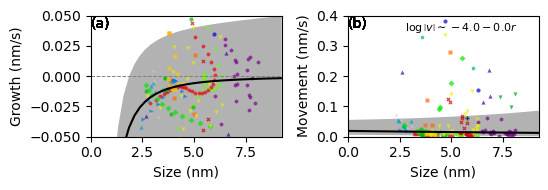

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.), sharex=True)

alpha = 0.7

marker_list = 'osv^p<>hHP*XD'

# Plot the growth
ax = axs[0]
for (gid, group), m in zip(track_data.groupby('void'), cycle(marker_list)):
    ax.text(0, 0.9, '(a)', transform=ax.transAxes, fontsize=10, weight='normal')
    group = group.sort_values('frame')
    
    # Determine the color for this group
    color = group['color'].iloc[0].tolist()
    color[3] = alpha  # Set the alpha
    ax.plot(group['radius'], group['radius_dt'], m, 
            ms=3, lw=1, mfc=color, mec='none', markevery=12)

ax.set_xlim(0, max(ax.get_xlim()) * 1.1)
ax.plot(ax.get_xlim(), [0, 0], '--', c='gray', lw=0.7)
ax.set_ylabel('Growth (nm/s)')
ax.set_ylim(-0.05, 0.05)

steps = np.linspace(0, ax.get_xlim()[1], 36)[1:]
dist = gt_model(steps, growth_gt_params)
mean = dist.mean()
std = dist.std()
ax.plot(steps, mean, 'k')
ax.fill_between(steps, mean + std, mean - std, alpha=0.3, color='k', edgecolor='none')

# Plot the movement
ax = axs[1]
for (gid, group), m in zip(track_data.groupby('void'), cycle(marker_list)):
    ax.text(0, 0.9, '(b)', transform=ax.transAxes, fontsize=10, weight='normal')
    # Determine the color for this group
    color = group['color'].iloc[0].tolist()
    color[3] = alpha  # Set the alpha
    ax.plot(group['radius'], group['velocity_mag'], m, 
            ms=3, lw=1, mfc=color, mec='none', markevery=12)

ax.set_ylim(0, 0.4)
ax.set_ylabel('Movement (nm/s)')

ax.text(0.3, 0.87, f'$\log\\left|v\\right|\sim{movement_lin_params[0]:.1f}{movement_lin_params[1]:+.1f}r$',
       transform=ax.transAxes, fontsize=8)

steps = np.linspace(*ax.get_xlim(), 64)
dist = linear_model(steps, movement_lin_params)
mean = dist.mean()
std = dist.std()
ax.plot(steps, np.exp(mean), 'k')
ax.fill_between(steps, np.exp(mean + std), np.exp(mean - std), alpha=0.3, color='k', edgecolor='none')


for ax in axs:
    ax.set_xlabel('Size (nm)')
fig.tight_layout()
fig.savefig(out_directory / 'figures/time-resolved-voids-by-size.png', dpi=320)

## Use MCMC Sampling to Estimate Parameter Uncertainties
The above only gives us point estimates for the values of the parameters, which are a good place to start but limited. It would be better to have uncertainties of each parameter, which we can access with Bayesian methods.

Here, we apply [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) to establish a distribution for all of our model parameters. In short, we'll build a tool that can generate samples from a distribution of likely parameters given the log probability function I created above.

We follow the [tutorial for EMCEE](https://emcee.readthedocs.io/en/stable/tutorials/line/).

Start with the growth parameters. First step is to make an initial guess and the sampler

In [35]:
def perform_mcmc_analysis(guess: np.ndarray, target: str, dist_function) -> tuple[np.ndarray, np.ndarray, float]:
    """Perform MCMC analysis to determine parameter means and covariance, and model evidence

    Args:
        priors: Initial estimate for parameters
        target: Name of the property we seek to predict
        dist_function: Function which generates probability distribution for observed property

    Returns:
        - Estimate for the mean
        - Estimate for the covariance
        - Log evidence
    """

    # Create the walker
    pos = guess - 1e-4 + 2e-4 * np.random.rand(32, len(guess))
    n_walkers, n_dim = pos.shape

    prob_fun = partial(log_probability, data=track_data, dist_function=dist_function, target_column=target)
    sampler = emcee.EnsembleSampler(
        n_walkers, n_dim, prob_fun
    )

    # Burn in and find the autocorrelation time. If the autocorrelation time fails, then add more samples
    state = sampler.run_mcmc(pos, 5000, progress=True)
    
    for _ in range(5):
        try:
            act = sampler.get_autocorr_time().max()
            break
        except emcee.autocorr.AutocorrError:
            state = sampler.run_mcmc(state, 10000, progress=True)
    else:
        raise ValueError('Did not converge')
    print(f'Assuming an autocorrelation time of {act:.1f}')

    # Run the sampling, discarding steps based on the autocorr length
    samples = sampler.get_chain(discard=int(act*8), thin=int(act / 2), flat=True)
    print(f'Pulled {samples.shape[0]} samples.')

    # Compute the mean and covariance
    growth_covariance = np.cov(samples.T)
    growth_means = np.mean(samples, axis=0)

    # Compute the evidence
    log_evidence = [
        prob_fun(x) for x in samples
    ]
    mean_log_evidence = np.logaddexp.reduce(log_evidence) - np.log(len(samples)) # Subtracting logarithms is equivalent to dividing

    return growth_means, growth_covariance, mean_log_evidence

In [36]:
gt_growth_mean, gt_growth_cov, gt_growth_evidence = perform_mcmc_analysis(growth_gt_params, 'radius_dt', gt_model)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:09<00:00, 40.03it/s]


ValueError: Did not converge

In [ ]:
lin_growth_mean, lin_growth_cov, lin_growth_evidence = perform_mcmc_analysis(growth_lin_params, 'radius_dt', linear_model)

In [ ]:
con_growth_mean, con_growth_cov, con_growth_evidence = perform_mcmc_analysis(growth_const_params, 'radius_dt', constant_model)

Repeat for the movement parameters

In [ ]:
lin_move_mean, lin_move_cov, lin_move_evidence = perform_mcmc_analysis(movement_lin_params, 'log_velocity_mag', linear_model)

In [ ]:
con_move_mean, con_move_cov, con_move_evidence = perform_mcmc_analysis(movement_const_params, 'log_velocity_mag', constant_model)

Save the Bayesian results

In [ ]:
with (out_directory / 'growth-parameters-bayesian.json').open('w') as fp:
    json.dump({
        'growth': {
            'gt': {'mean': gt_growth_mean.tolist(), 'covar': gt_growth_cov.tolist(), 'evidence': gt_growth_evidence},
            'linear': {'mean': lin_growth_mean.tolist(), 'covar': lin_growth_cov.tolist(), 'evidence': lin_growth_evidence},
            'constant': {'mean': con_growth_mean.tolist(), 'covar': con_growth_cov.tolist(), 'evidence': con_growth_evidence}
        },
        'movement': {
            'linear': {'mean': lin_move_mean.tolist(), 'covar': lin_move_cov.tolist(), 'evidence': lin_move_evidence},
            'constant': {'mean': con_move_mean.tolist(), 'covar': con_move_cov.tolist(), 'evidence': con_move_evidence},
        }
    }, fp, indent=2)